In [4]:
import pandas as pd
import numpy as np
import keras_contrib
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
import csv
import codecs
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(10)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from keras.preprocessing.text import text_to_word_sequence
from gensim.models.keyedvectors import KeyedVectors

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
tsvfile=open("/content/drive/My Drive/Colab Notebooks/BC5CDR-IOB/train.tsv",encoding="utf-8")
tsvreader = csv.reader(tsvfile, delimiter="\t")
data=[]
sentences=[]
words=[]
tags=[]
maxsentlen=0
for line in tsvreader:
    if line!=[]:
        data.append(line)
        if line[0] not in words:
            words.append(line[0])
        if line[1] not in tags:
            tags.append(line[1])
    else:
        sentences.append(data)
        if len(data)>maxsentlen:
            maxsentlen=len(data)
        data=[]

In [6]:
print(len(sentences))
print(len(words))

4560
9980


In [7]:
word_to_index = {w : i + 2 for i, w in enumerate(words)}
print(word_to_index[words[0]])
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
print(tag_to_index[tags[0]])

tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
print(idx2word[2])
idx2tag = {i: w for w, i in tag_to_index.items()}
print(len(tag_to_index))

2
1
Selegiline
6


In [0]:
# Number of data points passed in each iteration
batch_size =50
# Passes through entire dataset
epochs = 10
# Maximum length of review
max_len = maxsentlen+15
# Dimension of embedding vector
embedding_dim= 300

In [11]:
X = [[word_to_index[w[0]] for w in s] for s in sentences]
print(X[0],X[1])
count=0
for s in sentences:
    print(s)
    count=count+1
    if count>5:
        break
# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] [23, 12, 24, 25, 26, 8, 9, 10, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 7, 38, 39, 8, 9, 10, 11, 30, 40, 32, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 3, 51, 52, 39, 53, 54, 50, 3, 51, 55, 22]
[['Selegiline', 'B-Chemical'], ['-', 'O'], ['induced', 'O'], ['postural', 'B-Disease'], ['hypotension', 'I-Disease'], ['in', 'O'], ['Parkinson', 'B-Disease'], ["'", 'I-Disease'], ['s', 'I-Disease'], ['disease', 'I-Disease'], [':', 'O'], ['a', 'O'], ['longitudinal', 'O'], ['study', 'O'], ['on', 'O'], ['the', 'O'], ['effects', 'O'], ['of', 'O'], ['drug', 'O'], ['withdrawal', 'O'], ['.', 'O']]
[['OBJECTIVES', 'O'], [':', 'O'], ['The', 'O'], ['United', 'O'], ['Kingdom', 'O'], ['Parkinson', 'B-Disease'], ["'", 'I-Disease'], ['s', 'I-Disease'], ['Disease', 'I-Disease'], ['Research', 'O'], ['Group', 'O'], ['(', 'O'], ['UKPDRG', 'O'], [')', 'O'], ['trial', 'O'], ['found', 'O'], ['an', 'O'], ['increased', 'O'], ['mortality', 'O'

In [12]:
print(X[0])
len(X[0])

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


169

In [13]:
# Convert label to index
y = [[tag_to_index[w[1]] for w in s] for s in sentences]
print(y[0])
# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

[1, 2, 2, 3, 4, 2, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [14]:
num_tag = 5
print(num_tag)
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]
print(y[0][1],y[0][18])
print(len(y[0][1]))

5
[0. 0. 1. 0. 0. 0.] [0. 0. 1. 0. 0. 0.]
6


In [0]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [16]:
'''print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)'''

'print("Size of training input data : ", X_train.shape)\nprint("Size of training output data : ", np.array(y_train).shape)\nprint("Size of testing input data : ", X_test.shape)\nprint("Size of testing output data : ", np.array(y_test).shape)'

In [17]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])
len(X[0])

*****Before Processing first sentence : *****
 Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal .
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


169

In [18]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[1] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 B-Chemical O O B-Disease I-Disease O B-Disease I-Disease I-Disease I-Disease O O O O O O O O O O O
*****After Processing first sentence : *****
  [[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [20]:
path = "Embeddings/bio_GloVe_300.txt"
f = codecs.open(path, 'r', encoding='utf-8')
embeddings_index = {}
for line in f:
    split_line = line.split()
    word = split_line[0]
    embedding1 = np.array([float(val) for val in split_line[1:]])
    embeddings_index[word] = embedding1
print('Found %s word vectors.' % len(embeddings_index))
emb=embeddings_index['gene'].tolist()
print(len(emb))
print(emb)

Found 633966 word vectors.
300
[-0.170414, 0.124066, -0.11531, -0.48346, -0.010218, 0.212453, -0.059106, -0.011211, -0.273115, -0.031161, -0.061578, -0.246429, 0.301874, -0.047402, -0.179771, -0.103855, -0.247374, 0.330996, 0.041749, 0.447276, 0.482648, 0.365678, 0.092462, 0.301248, -0.023064, -0.089027, 0.14914, 0.756354, 0.450109, -0.406125, 0.457199, 0.07989, -0.307475, 0.030622, 0.341248, 0.22113, 0.801639, 0.474214, 0.176855, -0.025022, -0.626881, 0.349852, -0.119905, 0.289109, -0.448433, 0.212642, 0.43373, -0.498386, 0.559984, -0.237298, -0.364749, 0.247834, 0.71511, -0.27462, 0.243815, 0.33679, 0.156935, 0.113424, 0.469642, 0.394421, -0.89875, 0.13933, -0.088935, 0.015076, 0.671514, -0.172198, -0.084477, 0.430311, -0.582824, -0.035599, -0.487345, -0.145008, 0.031857, 0.366613, -0.09774, -0.54506, -0.249634, -0.728636, -0.122298, 0.262496, 0.163828, 0.122999, -0.085251, -1.438981, 0.403183, -0.475071, 0.549353, 0.097049, 0.352601, -0.062208, -0.377554, -0.666492, -0.284039, 0.716

In [0]:
num_words=len(word_to_index) + 1
embedding_matrix = np.zeros((len(words)+2, embedding_dim))
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_layer = Embedding(len(words)+2,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_len,
                            trainable=False)

In [23]:
num_tags = 5
def createmodel():
    # Model architecture
    input = Input(shape = (max_len,))
    model=embedding_layer(input)
    model = Bidirectional(LSTM(units = 100, return_sequences=True, recurrent_dropout=0.1))(model)
    model = TimeDistributed(Dense(50, activation="relu"))(model)
    crf = CRF(num_tags+1)  # CRF layer
    out = crf(model)  # output

    model = Model(input, out)
    model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

    model.summary()
    return model

model=createmodel()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 169)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 169, 300)          2994600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 169, 200)          320800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 169, 50)           10050     
_________________________________________________________________
crf_1 (CRF)                  (None, 169, 6)            354       
Total params: 3,325,804
Trainable params: 33

In [0]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [25]:
history = model.fit(X, np.array(y), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1)




Train on 4104 samples, validate on 456 samples
Epoch 1/10





4104/4104 [==============================] - 58s 14ms/step - loss: 0.1692 - crf_viterbi_accuracy: 0.9483 - val_loss: 0.0408 - val_crf_viterbi_accuracy: 0.9856
Epoch 2/10
4104/4104 [==============================] - 54s 13ms/step - loss: 0.0319 - crf_viterbi_accuracy: 0.9888 - val_loss: 0.0305 - val_crf_viterbi_accuracy: 0.9885
Epoch 3/10
4104/4104 [==============================] - 55s 13ms/step - loss: 0.0247 - crf_viterbi_accuracy: 0.9909 - val_loss: 0.0288 - val_crf_viterbi_accuracy: 0.9892
Epoch 4/10
4104/4104 [==============================] - 54s 13ms/step - loss: 0.0197 - crf_viterbi_accuracy: 0.9922 - val_loss: 0.0213 - val_crf_viterbi_accuracy: 0.9910
Epoch 5/10
4104/4104 [==============================] - 54s 13ms/step - loss: 0.0162 - crf_viterbi_accuracy: 0.9932 - val_loss: 0.0240 - val_crf_viterbi_accuracy: 0.9893
Epoch 6/10
4104/4104 [==============================] - 54s 13ms/step - loss: 0.0132 - crf_vite

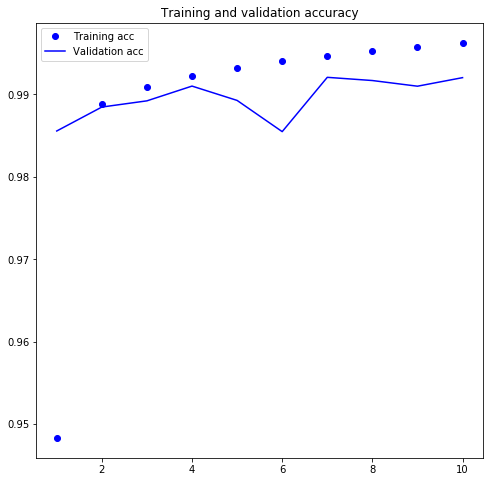

In [26]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

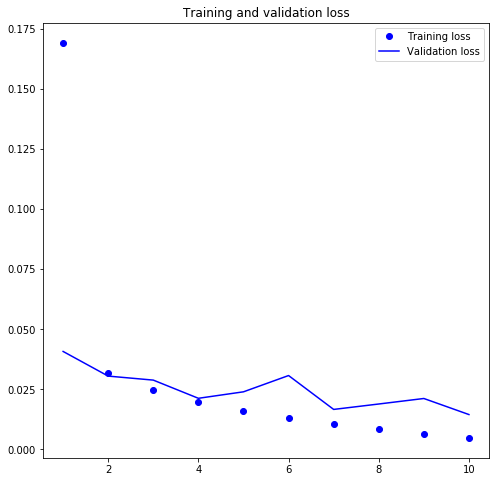

In [27]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
tsvfile=open("BC5CDR-IOB/test.tsv",encoding="utf-8")
tsvreader = csv.reader(tsvfile, delimiter="\t")
data1=[]
sentences1=[]
words1=[]
tags1=[]
for line in tsvreader:
    if line!=[]:
        data1.append(line)
        if line[0] not in words1:
            words1.append(line[0])
        if line[1] not in tags1:
            tags1.append(line[1])
    else:
        sentences1.append(data1)
        data1=[]

X1 = [[word_to_index[w[0] if w[0] in words else "UNK"] for w in s] for s in sentences1]
print(X1[0],X1[1])
count=0
for s in sentences1:
    count=count+1
    if count>5:
        break
# Padding each sequence to have same length  of each word
X1 = pad_sequences(maxlen = max_len, sequences = X1, padding = "post", value = word_to_index["PAD"])
y1 = [[tag_to_index[w[1]] for w in s] for s in sentences1]
# padding
y1 = pad_sequences(maxlen = max_len, sequences = y1, padding = "post", value = tag_to_index["PAD"])
num_tag = 5
# One hot encoded labels
y1=[to_categorical(i, num_classes = num_tag + 1) for i in y1]

In [0]:
y_pred = model.predict(X1)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y1, -1)

In [0]:
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [35]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 81.0%


In [36]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

  B-Chemical       0.77      0.77      0.77      5385
   B-Disease       0.81      0.65      0.72      4424
  I-Chemical       0.68      0.63      0.66      1628
   I-Disease       0.66      0.73      0.69      2737
           O       0.97      0.98      0.97    110576
         PAD       1.00      1.00      1.00    685943

    accuracy                           0.99    810693
   macro avg       0.82      0.79      0.80    810693
weighted avg       0.99      0.99      0.99    810693



In [37]:
print(y_test_true[0])

['B-Disease', 'I-Disease', 'I-Disease', 'B-Disease', 'I-Disease', 'O', 'O', 'O', 'O', 'B-Chemical', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'O', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'P

In [38]:
print(y_pred[0])

['O', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'O', 'O', 'O', 'O', 'B-Chemical', 'O', 'O', 'O', 'O', 'O', 'B-Disease', 'I-Disease', 'O', 'B-Disease', 'I-Disease', 'I-Disease', 'O', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD

In [39]:
y_pred[0][1:16]==y_test_true[0][1:16]

False

In [0]:
    ##Exact Match
def calresultExact(y_test_true,y_pred):
    TP=0
    TN=0
    FP=0
    FN=0
    i=0
    nument=0
    while i<len(y_test_true):
        j=0
      #print(i)
        while j <len(y_test_true[i]):
          #print('j ',j)
            if y_test_true[i][j]=='B-Disease':
                st=j
                nument=nument+1
                j=j+1
                while (y_test_true[i][j]=='I-Disease') and j<len(y_test_true[i]):
                    j=j+1
                  #print('inside ',j)
                end=j
                if y_test_true[i][st:end]==y_pred[i][st:end]:
                    TP=TP+1
                else:
                    FN=FN+1

            elif y_test_true[i][j]=='B-Chemical':
                st=j
                nument=nument+1
                j=j+1
                while (y_test_true[i][j]=='I-Chemical') and j<len(y_test_true[i]):
                    j=j+1
                  #print('inside ',j)
                end=j
                if y_test_true[i][st:end]==y_pred[i][st:end]:
                    TP=TP+1
                else:
                    FN=FN+1
            elif y_test_true[i][j]=='O' and y_pred[i][j]=='O':
                TN=TN+1
                j=j+1

            elif y_test_true[i][j]=='O' and y_pred[i][j]!='O':
                FP=FP+1
                j=j+1

            elif y_test_true[i][j]=='PAD':
                j=j+1

        i=i+1

Precision=TP/(TP+FP)
print(Precision)
Recall=TP/(TP+FN)
print(Recall)
F1=(2*Precision*Recall)/(Precision+Recall)
print(F1)
mat=[[TP,FP],[FN,TN]]
print(mat)

In [0]:
##Partial Match
def calresultPartial(y_test_true,y_pred):
    TP=0
    TN=0
    FP=0
    FN=0
    i=0
    nument=0
    while i<len(y_test_true):
        j=0
      #print(i)
        while j <len(y_test_true[i]):
          #print('j ',j)
            if y_test_true[i][j]=='B-Disease':
                st=j
                nument=nument+1
                j=j+1
                while (y_test_true[i][j]=='I-Disease') and j<len(y_test_true[i]):
                    j=j+1
                  #print('inside ',j)
                end=j
                found=0
                for k in range(st,end):
                    if y_test_true[i][k]==y_pred[i][k]:
                        found=1
                        break
                if found==1:
                    TP=TP+1
                else:
                    FN=FN+1
              
            elif y_test_true[i][j]=='B-Chemical':
                st=j
                nument=nument+1
                j=j+1
                while (y_test_true[i][j]=='I-Chemical') and j<len(y_test_true[i]):
                    j=j+1
                  #print('inside ',j)
                end=j
                found=0
                for k in range(st,end):
                    if y_test_true[i][k]==y_pred[i][k]:
                        found=1
                        break
                if found==1:
                    TP=TP+1
                else:
                    FN=FN+1
            elif y_test_true[i][j]=='O' and y_pred[i][j]=='O':
                TN=TN+1
                j=j+1

            elif y_test_true[i][j]=='O' and y_pred[i][j]!='O':
                FP=FP+1
                j=j+1

            elif y_test_true[i][j]=='PAD':
                j=j+1


        i=i+1
      

Precision=TP/(TP+FP)
print(Precision)
Recall=TP/(TP+FN)
print(Recall)
F1=(2*Precision*Recall)/(Precision+Recall)
print(F1)
mat=[[TP,FP],[FN,TN]]
print(mat)

In [42]:
len(y_test_true)

4797

In [43]:
calresultExact(y_test_true,y_pred)
print('--------------------------------')
calresultPartial(y_test_true,y_pred)

0.7273592890393568
0.7008869405647874
0.713877784123358
[[6875, 2577], [2934, 107999]]
--------------------------------
0.7386939768809572
0.7426852890202875
0.7406842560113874
[[7285, 2577], [2524, 107999]]
